In [2]:
%%bash
pip3 install opencv-python
pip3 install gymnasium[atari]
pip3 install gymnasium[accept-rom-license]
pip3 install numpy
pip3 install matplotlib
pip3 install opencv-python
pip3 install imageio-ffmpeg
pip3 install imageio
pip3 install torch


In [3]:
%%bash
pip3 install numpy 
pip3 install gymnasium[atari]
pip3 install gymnasium[accept-rom-license]

In [4]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

from IPython import display

# ALE/MsPacman-v5 environment


In [5]:
# env = gym.make('ALE/MsPacman-v5', obs_type="grayscale")
env = gym.make('ALE/MsPacman-v5')
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Box(0, 255, (210, 160, 3), uint8)
Action space:  Discrete(9)


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


MsPacman has the action space of Discrete(9) with the table below listing the meaning of each action’s meanings.

| Value | Meaning | Value | Meaning | Value | Meaning |
| ----- | ----- | ----- | ----- | ----- | ----- |
| 0 | NOOP | 1 | UP | 2 | RIGHT |
| 3 | LEFT | 4 | DOWN | 5 | UPRIGHT |
| 6 | UPLEFT | 7 | DOWNRIGHT | 8 | DOWNLEFT|


For Detail informaiton:
- https://gymnasium.farama.org/environments/atari/ms_pacman/#mspacman
- https://atariage.com/manual_thumbs.php?SystemID=2600&SoftwareLabelID=924&ItemTypeID=


(210, 160, 3)


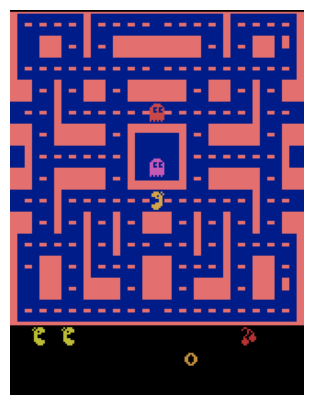

In [18]:
# visualize the observation_space
state, info = env.reset()
print(state.shape)

plt.figure(figsize=(5, 5))
plt.imshow(state)
plt.axis('off')
plt.show()

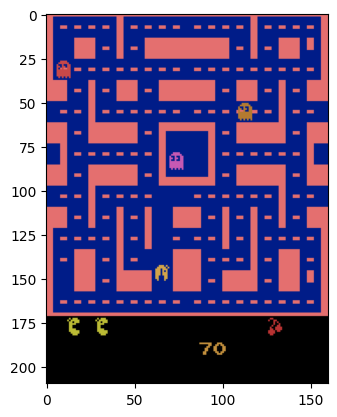

In [19]:
# visualize the MsPacman game
img = plt.imshow(state) #initialize figure
for _ in range(100):    
    action = env.action_space.sample() # random pick an action
    state, reward, terminated, truncated, info = env.step(action)
    img.set_data(state) # just update the data
    display.display(plt.gcf()) # display current figure
    display.clear_output(wait=True)

## OpenAI Gym Wrapper for Image Environment

In [20]:
import cv2

def preprocess(img, image_hw=84):
    img = img[1:172, :] # MsPacman-specific cropping: 1 row ~ 172 row
    img = cv2.resize(img, dsize=(image_hw, image_hw)) # rescale to 84x84
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
    return img

In [21]:
class ImageEnv(gym.Wrapper):
    def __init__(
        self,
        env,
        skip_frames=4,
        stack_frames=4,
        image_hw=84,
        initial_no_op=50,
        **kwargs
    ):
        super(ImageEnv, self).__init__(env, **kwargs)
        self.initial_no_op = initial_no_op
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames
        self.image_hw = image_hw
    
    def reset(self):
        # Reset the original environment.
        state, info = self.env.reset()

        # Do nothing for the next `self.initial_no_op` steps
        for _ in range(self.initial_no_op):
            state, reward, terminated, truncated, info = self.env.step(0)
        
        # Convert the frame `state` to Grayscale and resize it
        state = preprocess(state, self.image_hw)

        # The initial observation is simply a copy of the frame `s`, replicate 4 times of frame 'state'
        self.stacked_state = np.tile(state, (self.stack_frames, 1, 1))  # [4, 84, 84]
        return self.stacked_state, info
    
    def step(self, action):
        # We take an action for self.skip_frames steps
        rewards = 0
        for _ in range(self.skip_frames):
            state, reward, terminated, truncated, info = self.env.step(action)
            rewards += reward
            if terminated or truncated:
                break

        # Convert the frame `state` to Grayscale and resize it
        state = preprocess(state, self.image_hw)

        # Push the current frame `state` at the end of self.stacked_state, also remove the oldest frame in stacked_state
        self.stacked_state = np.concatenate((self.stacked_state[1:], state[np.newaxis]), axis=0)

        return self.stacked_state, reward, terminated, truncated, info

The shape of an observation:  (4, 84, 84)


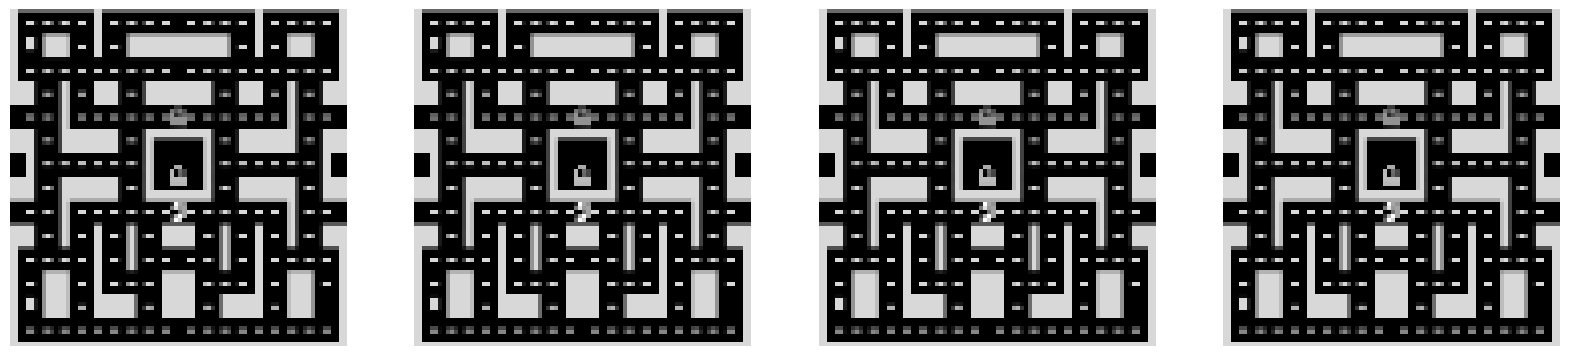

In [37]:
env = gym.make('ALE/MsPacman-v5')
env = ImageEnv(env)

s, _ = env.reset()
print("The shape of an observation: ", s.shape)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

Let’s do LEFT action for the next 4 steps. You can see our car was moving forward!

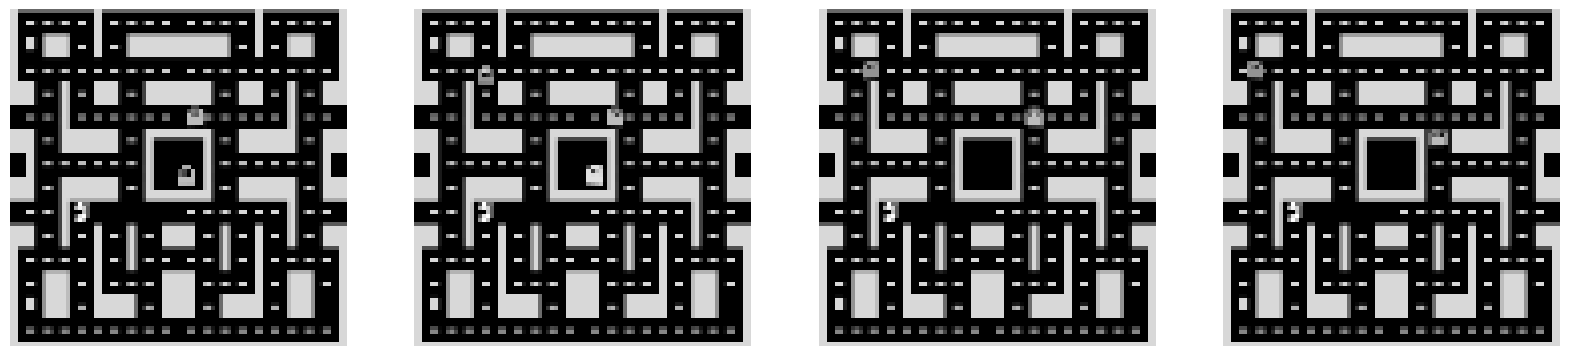

In [40]:
for i in range(4):
    s, r, terminated, truncated, info = env.step(3)  # 3rd action is `LEFT`
    s, r, terminated, truncated, info = env.step(3)  # 3rd action is `LEFT`

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()